# Example FIDA analysis
FIDA analysis on freely diffusing 20 nm fluorescent beads. In **spot-variation FIDA** analysis, different intensity traces are obtained by summing counts from a different number of detector elements. Fitting the resulting histograms with the emitter concentration and brightness as fit parameters should reveal an increasing brightness for an increased number of active detector elements, while the concentration should remain the same.

Import packages

In [17]:
from brighteyes_ffs.fcs.fcs2corr import fcs_load_and_corr_split as correlate
from brighteyes_ffs.fcs.fcs2corr import fcs_av_chunks
from brighteyes_ffs.fcs.get_fcs_info import get_metafile_from_file, get_file_info
from brighteyes_ffs.pch.pch_fit import fit_pch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

File name and correlation settings

In [18]:
file = "Y:/Data MMS server/FCS_Setup/NIsystem/2025/2025-04-04/01_20nm_beads_power_80percP_488_fcs_y_250_x_250.bin"
list_of_g = ['central', 'sum3', 'sum5']
list_of_g_out = ['central', 'sum3', 'sum5']
averaging = None
algorithm = 'pch'
binsize = 10
chunksize = 2.0

In [19]:
mdata = get_file_info(get_metafile_from_file(file))

## Calculate histograms

In [20]:
G, time_trace = correlate(file, list_of_g=list_of_g, accuracy=30, binsize=binsize, split=chunksize, time_trace=True, averaging=averaging, list_of_g_out=list_of_g_out, algorithm=algorithm)

+--------------------+
| Loading chunk 1/50 |
+--------------------+
data table: (200000, 2)
Converting data to counts
Done.
     --> central: Calculating autocorrelation central detector element
     --> sum3: Calculating autocorrelation sum3x3
     --> sum5: Calculating autocorrelation sum5x5
+--------------------+
| Loading chunk 2/50 |
+--------------------+
data table: (200000, 2)
Converting data to counts
Done.
     --> central: Calculating autocorrelation central detector element
     --> sum3: Calculating autocorrelation sum3x3
     --> sum5: Calculating autocorrelation sum5x5
+--------------------+
| Loading chunk 3/50 |
+--------------------+
data table: (200000, 2)
Converting data to counts
Done.
     --> central: Calculating autocorrelation central detector element
     --> sum3: Calculating autocorrelation sum3x3
     --> sum5: Calculating autocorrelation sum5x5
+--------------------+
| Loading chunk 4/50 |
+--------------------+
data table: (200000, 2)
Converting data to 

     --> central: Calculating autocorrelation central detector element
     --> sum3: Calculating autocorrelation sum3x3
     --> sum5: Calculating autocorrelation sum5x5
+---------------------+
| Loading chunk 30/50 |
+---------------------+
data table: (200000, 2)
Converting data to counts
Done.
     --> central: Calculating autocorrelation central detector element
     --> sum3: Calculating autocorrelation sum3x3
     --> sum5: Calculating autocorrelation sum5x5
+---------------------+
| Loading chunk 31/50 |
+---------------------+
data table: (200000, 2)
Converting data to counts
Done.
     --> central: Calculating autocorrelation central detector element
     --> sum3: Calculating autocorrelation sum3x3
     --> sum5: Calculating autocorrelation sum5x5
+---------------------+
| Loading chunk 32/50 |
+---------------------+
data table: (200000, 2)
Converting data to counts
Done.
     --> central: Calculating autocorrelation central detector element
     --> sum3: Calculating autoc

## Plot time trace
The bad chunks, shown in red, were identified from the autocorrelation curves in an FFS analysis (not shown here). These are excluded for the histogram calculation.

In [21]:
num_chunks = int(np.floor(mdata.duration / chunksize))
splits = np.arange(0, (num_chunks+1)*chunksize, chunksize)
good_chunks = [2, 3, 4, 5, 6, 9, 10, 11, 13, 14, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 29, 30, 33, 34, 37, 39, 42, 43, 44, 45, 46, 48, 49]

Text(0, 0.5, 'Photon counts per bin')

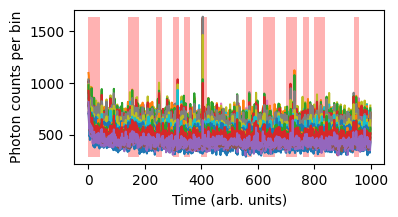

In [22]:
fig, ax = plt.subplots(figsize=(4,2))
for i in range(25):
    plt.plot(time_trace[:,i])
ymin = np.min(time_trace)
ymax = np.max(time_trace)
if len(splits) <= 101:
    # color chunks red if not used for calculating average correlation
    if good_chunks is not None:
        for i in range(len(splits) - 1):
            if i not in good_chunks:
                rect = patches.Rectangle((1000/mdata.duration*splits[i], ymin), 1000/mdata.duration*(splits[i+1]-splits[i]), ymax-ymin, fc='r', alpha=0.3)
                ax.add_patch(rect)
plt.xlabel('Time (arb. units)')
plt.ylabel('Photon counts per bin')

## Plot histograms
First, calculate the average correlation of the good chunks. Then, plot the result.

In [23]:
G.average_chunks(good_chunks)

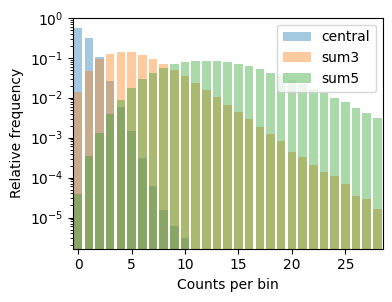

In [24]:
plt.figure(figsize=(4,3))
for corr in list_of_g_out:
    Gsingle = getattr(G, corr + '_averageX')
    plt.bar(Gsingle[0:,0], Gsingle[0:,1], label=corr, alpha=0.4)
plt.legend()
plt.xlabel('Counts per bin')
plt.ylabel('Relative frequency')
plt.xlim([-0.5,28.5])
plt.xscale('linear')
plt.yscale('log')

## Fit histograms
Fit with a 2 component fit function, but the second component set to brightness = 0, since we have only 1 component.

Parameters:
* Concentration species 1 (/um^3)
* Concentration species 2 (/um^3)
* Brightness species 1 (kHz)
* Brightness species 2 (kHz)
* Dark count rate (kHz)
* Bin time (ms)
* Voxel volume of the PSF model (um^3). If the psf is given as a list [w0, z0/w0], the volume is 2e-6.
* Beam waist w0 (nm)
* Shape parameter
* Number of spatial bins used for the numerical integration of the FIDA integral

### Individual fits

In [25]:
from brighteyes_ffs.pch.pch_fit import fitfun_pch_nc as my_fit_fun

In [26]:
w0 = [328.2, 364.2, 436.3] # beam waist for central, sum3x3, and sum5x5 (nm)
dcr = [0.1, 1, 2.0] # dark count rates (kHz)

fitresults = []
for i, corr in enumerate(list_of_g_out):
    Gsingle = getattr(G, corr + '_averageX')
    Gexp = Gsingle[0:30,1] # your chosen range for fitting
    fit_info = np.asarray([True, False, True, False, False, False, False, False, False, False]) # use 1 for parameters that have to be fitted, 0 otherwise
    param = np.asarray([4, 1e-10, 30, 1e-10, dcr[i], 0.1, 2e-06, w0[i], 4.0, 100000.0])
    lBounds = np.asarray([1e-10, 1e-10, 1e-10, 1e-10, 0.0, 1e-12, 1e-12, 1e-12, 1e-12, 10.0]) # the lower bounds for the fit parameters
    uBounds = np.asarray([1e12, 1e12, 1e12, 1e12, 1e5, 1e12, 1e12, 1e12, 1e12, 1e12]) # the upper bounds for the fit parameters
    nparam = len(param) - 3
    fitresult = fit_pch(Gexp, fit_info[0:nparam], param[0:nparam], psf=list(param[nparam:nparam+2]), fitfun=my_fit_fun, lBounds=lBounds[0:nparam], uBounds=uBounds[0:nparam], n_bins=param[nparam+2], minimization="absolute")
    fitresults.append(fitresult)

(1e-05, 1)

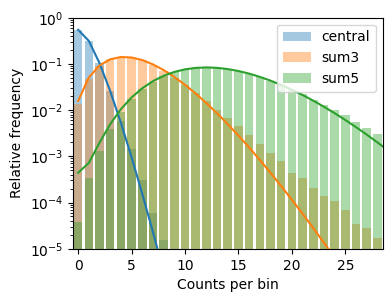

In [27]:
plt.figure(figsize=(4,3))
for i, corr in enumerate(list_of_g_out):
    # plot correlation
    Gsingle = getattr(G, corr + '_averageX')
    plt.bar(Gsingle[0:,0], Gsingle[0:,1], label=corr, alpha=0.4)
    # plot fit
    fitresult = fitresults[i]
    plt.plot(Gsingle[0:30,0], Gsingle[0:30,1]-fitresult.fun, linewidth=1.5)
plt.legend()
plt.xlabel('Counts per bin')
plt.ylabel('Relative frequency')
plt.xscale('linear')
plt.yscale('log')
plt.xlim([-0.5,28.5])
plt.ylim([1e-5,1])

As expected, the fit returns almost identical results for the concentration from the three different histograms. The brighness increases as we increase the number of detector elements:

In [28]:
for i in range(3):
    fitresult = fitresults[i].x
    print(f"concentration ({list_of_g_out[i]}) = {fitresult[0]:.2f} /um^3")

print()

for i in range(3):
    fitresult = fitresults[i].x
    print(f"brightness ({list_of_g_out[i]}) = {fitresult[2]:.2f} kHz")

concentration (central) = 8.50 /um^3
concentration (sum3) = 8.05 /um^3
concentration (sum5) = 9.33 /um^3

brightness (central) = 2.62 kHz
brightness (sum3) = 17.37 kHz
brightness (sum5) = 21.82 kHz


### Global fit

The concentration should not depend on the number of detector elements considered. Thus, we can do a global fit of all histograms simultaneously, forcing the concentration to be equal in all histograms.

In [29]:
from brighteyes_ffs.pch.pch_fit import fitfun_pch_nc_global as my_fit_fun # you chose PCH 2 components as the fit function

In [36]:
w0 = [328.2, 364.2, 436.3] # beam waist for central, sum3x3, and sum5x5 (nm)
SP = [4, 4, 4] # shape parameter z0/w0
dcr = [0.1, 10, 2.0] # dark count rates (kHz)
bin_time = 0.1

pch_all = np.zeros((30, len(list_of_g_out)))
param = np.zeros((10, len(list_of_g_out)))
psf = []

for i, corr in enumerate(list_of_g_out):
    Gsingle = getattr(G, corr + '_averageX')
    pch_all[:, i] = Gsingle[0:30,1] # your chosen range for fitting
    param[:, i] = np.asarray([10, 1e-10, 20, 1e-10, dcr[i], bin_time, 2e-06, w0[i], SP[i], 100000.0])
    psf.append(w0[i])
    psf.append(SP[i])

fit_info = np.asarray([True, False, True, False, False, False, False, False, False, False]) # use 1 for parameters that have to be fitted, 0 otherwise
global_param = np.asarray([True, True, False, False, False, False, False, False, False, False]) # use 1 for global parameters
lBounds = np.asarray([1e-10, 1e-10, 1e-10, 1e-10, 0.0, 1e-12, 1e-12, 1e-12, 1e-12, 10.0]) # the lower bounds for the fit parameters
uBounds = np.asarray([1e12, 1e12, 1e12, 1e12, 1e5, 1e12, 1e12, 1e12, 1e12, 1e12]) # the upper bounds for the fit parameters
nparam = len(param) - 3

fitresult = fit_pch(pch_all, fit_info[0:nparam], param[0:nparam,:], psf=psf, fitfun=my_fit_fun, global_param=global_param[0:nparam], lBounds=lBounds[0:nparam], uBounds=uBounds[0:nparam], n_bins=param[nparam+2,0], minimization="absolute")

(1e-05, 1)

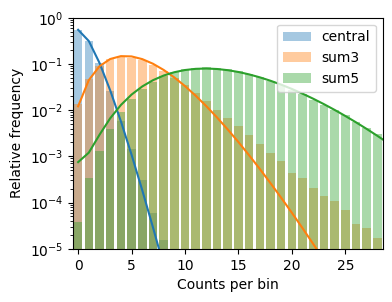

In [37]:
plt.figure(figsize=(4,3))
for i, corr in enumerate(list_of_g_out):
    # plot correlation
    Gsingle = getattr(G, corr + '_averageX')
    plt.bar(Gsingle[0:,0], Gsingle[0:,1], label=corr, alpha=0.4)
    # plot fit
    residuals = fitresult.fun[:,i]
    plt.plot(Gsingle[0:30,0], Gsingle[0:30,1]-residuals, linewidth=1.5)
plt.legend()
plt.xlabel('Counts per bin')
plt.ylabel('Relative frequency')
plt.xscale('linear')
plt.yscale('log')
plt.xlim([-0.5,28.5])
plt.ylim([1e-5,1])

In [38]:
for i in range(3):
    fitr = fitresult.x[:,i]
    print(f"concentration ({list_of_g_out[i]}) = {fitr[0]:.2f} /um^3")

print()

for i in range(3):
    fitr = fitresult.x[:,i]
    print(f"brightness ({list_of_g_out[i]}) = {fitr[2]:.2f} kHz")

concentration (central) = 7.35 /um^3
concentration (sum3) = 7.35 /um^3
concentration (sum5) = 7.35 /um^3

brightness (central) = 3.05 kHz
brightness (sum3) = 15.66 kHz
brightness (sum5) = 27.81 kHz
